# Proyecto de Telecomunicaciones
Buenas tardes, espero que se encuentren bien, envio mi proyecto. Saludos

Link Presentacion - Drive

https://drive.google.com/file/d/1nd4h3LOJK9awBtAzMBatsNrKDzxBrzDC/view?usp=drive_link

Link Tableu

https://public.tableau.com/app/profile/marco.estrada.ocampo/viz/ProyectoFinal_17497059866480/Dashboard1?publish=yes

Del enunciado tengo estas hipotesis
- hipotesis, Las llamadas entrantes y salientes tienen la misma duración.
- hipotesis, el tiempo de espera es el mismo para las llamadas entrantes y salientes

In [181]:
#Importar Librerias 
import pandas as pd
import math as mth
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [182]:
#recuperacion de los DF
telecom_clients=pd.read_csv('./telecom_clients_us.csv')
telecom_dataset=pd.read_csv('./telecom_dataset_us.csv')

In [183]:
#Visualizamos la informacion del dataset telecom_clients
print(telecom_clients.head())
telecom_clients.info()

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [184]:
#Visualizamos la informacion del dataset telecom_dataset
print(telecom_dataset.head())
telecom_dataset.info()

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Coun

In [185]:
#Conversion de los datos 
telecom_clients['date_start']=pd.to_datetime(telecom_clients['date_start'] )
telecom_dataset['date']=pd.to_datetime(telecom_dataset['date'] )
telecom_dataset['date'] = telecom_dataset['date'].dt.tz_localize(None)  
telecom_dataset

user_id       date direction internal  operator_id  is_missed_call  \
0       166377 2019-08-04        in    False          NaN            True   
1       166377 2019-08-05       out     True     880022.0            True   
2       166377 2019-08-05       out     True     880020.0            True   
3       166377 2019-08-05       out     True     880020.0           False   
4       166377 2019-08-05       out    False     880022.0            True   
...        ...        ...       ...      ...          ...             ...   
53897   168606 2019-11-10       out     True     957922.0            True   
53898   168606 2019-11-11       out     True     957922.0           False   
53899   168606 2019-11-15       out     True     957922.0           False   
53900   168606 2019-11-15       out     True     957922.0           False   
53901   168606 2019-11-19        in    False          NaN            True   

       calls_count  call_duration  total_call_duration  
0                2              0                    4  
1                3              0                    5  
2                1              0                    1  
3                1             10                   18  
4                3              0                   25  
...            ...            ...                  ...  
53897            1              0                   38  
53898            2            479                  501  
53899            4           3130                 3190  
53900            4           3130                 3190  
53901            2              0                   64  

[53902 rows x 9 columns]

In [186]:
#Ya que se requieren los numeros de operador_id procedemos a eliminar los que no se tengan.
telecom_dataset.dropna(subset=['operator_id'],inplace=True)

In [187]:
#Debido a la cantidad de datos que tenemos los 60 valores vacios de internal no afectan muchop
#Por lo que podriamos eliminar los valores.
telecom_dataset.dropna(subset=['internal'],inplace=True)

In [188]:
#conversion de datos
telecom_dataset['operator_id']=telecom_dataset['operator_id'].astype(int)

In [189]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45670 non-null  int64         
 1   date                 45670 non-null  datetime64[ns]
 2   direction            45670 non-null  object        
 3   internal             45670 non-null  object        
 4   operator_id          45670 non-null  int64         
 5   is_missed_call       45670 non-null  bool          
 6   calls_count          45670 non-null  int64         
 7   call_duration        45670 non-null  int64         
 8   total_call_duration  45670 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(5), object(2)
memory usage: 3.2+ MB


In [190]:
#Determinar el numero de operadores 
telecom_dataset['operator_id'].nunique()

1092

In [191]:
#Determinar el numero de usuarios en el registro
telecom_dataset['user_id'].nunique()

290

In [192]:
telecom_clients['user_id'].nunique()

732

In [193]:
#Fechas de registro de la clientela
telecom_clients['date_start'].nunique()

73

Esto nos dice que en nuestra cartera de cliente tenemos 732 clientes pero los datasets que tenemos solo son la operacion de 290 clientes distintos.

In [194]:
#Determinar la cantidad de tarifas.
telecom_clients['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [195]:
#Se tienen 118 fechas distintas 
telecom_dataset['date'].nunique()

118

out    31717
in     13953
Name: direction, dtype: int64


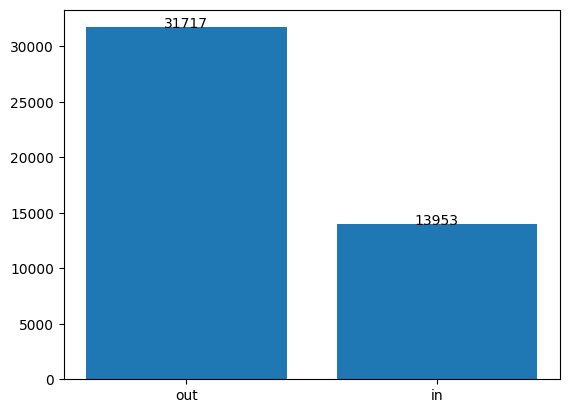

In [196]:

direction=telecom_dataset['direction'].value_counts()
print(direction)
plt.bar(direction.index,direction.values)
for i, value in enumerate(direction.values):
    plt.text(x=i, y=value + 5, s=str(value), ha='center')

plt.show()

0       15213
1         199
7         141
15        124
13        124
        ...  
2950        1
2773        1
4997        1
2837        1
6629        1
Name: call_duration, Length: 5339, dtype: int64


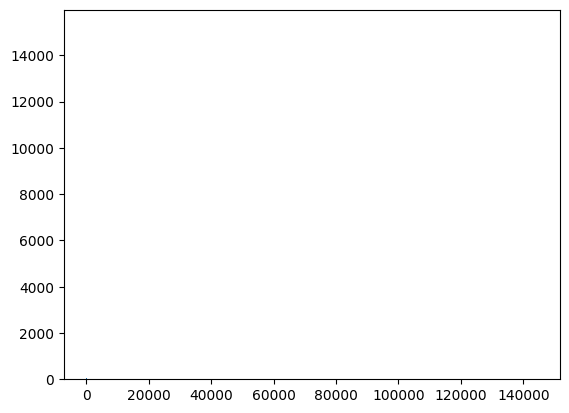

In [226]:

direction=telecom_dataset['call_duration'].value_counts()
print(direction)
plt.bar(direction.index,direction.values)
plt.show()

Podemos ver que la mayoria de los datos esta en valores pequeños.

In [198]:
telecom_count=telecom_dataset.groupby('operator_id').agg({'calls_count':'sum'}).sort_values(by='calls_count',ascending=False)
telecom_count.head(15)

calls_count
operator_id             
885876             66049
885890             66016
929428             24572
925922             22210
908640             16699
929426             12041
879898              7973
945286              7919
945302              7059
893804              6570
913938              5657
929424              5437
952948              5421
921318              5345
904016              5175

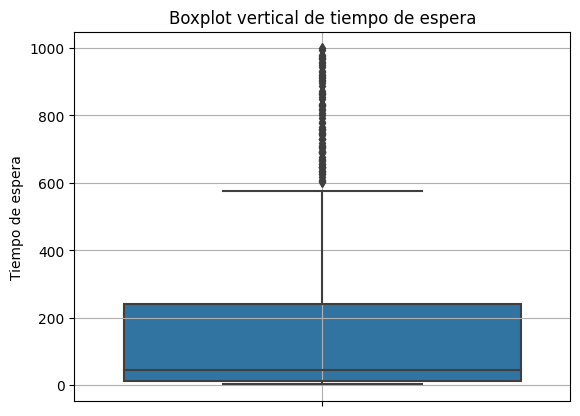

In [199]:
filtro=telecom_count[(telecom_count['calls_count']<1000)&(telecom_count['calls_count']>1)]
sns.boxplot(y=filtro['calls_count'])  
plt.title('Boxplot vertical de tiempo de espera')
plt.ylabel('Tiempo de espera')
plt.grid(True)
plt.show()

# Pruebas para considerar a un operador no eficaz

In [200]:
'''Condicion 1 para ser un operador no eficaz...
un tiempo de espera prolongado para las llamadas entrantes.'''
#determinaremos el tiempo de espera por llamada, mas adelante se determinara si es entrante.
telecom_dataset['waiting_time']=telecom_dataset['total_call_duration']-telecom_dataset['call_duration']


In [201]:
'''Para determinar si el tiempo de espera es demasiado para las llamadas entrantes 
Procedemos a usar percentile, esto nos dara una idea de como estan distribuidos los 
valores. para esto, usaremos los valores medios de cada usuario en el tiempo de espera'''
#Primero agrupamos por operador y determinamos su mediana, es decir en que tiempo tiene
#el 50% de sus llamadas
telecom_dataset_in=telecom_dataset[telecom_dataset['direction']=='in']
waiting_time_by_operator=telecom_dataset_in.groupby('operator_id').agg({'waiting_time':'median'})

#usamos describe para ver el comportamiento de la columna waiting time pero usamos percentile
#para ver que valor es el que tienen los operadores por debajo de cada porcentaje.
print(waiting_time_by_operator.describe())
print(np.percentile(waiting_time_by_operator['waiting_time'],[80,90,95]))

       waiting_time
count    754.000000
mean      50.220822
std       90.261491
min        1.000000
25%       15.000000
50%       25.250000
75%       48.000000
max      971.000000
[ 56.     96.4   167.375]


usaremos el valor de 56 en el cual el 80% de los operadores tienen tiempos por debajo de esa cantidad.

Ahora determinaremos si el operador fue no eficaz en esa llamada, lo que se pretende es determinar el numero de llamadas en la cual fue no eficaz y determinar la tasa con respecto al total de llamadas que tuvo.

In [202]:
#Condicion tiempo de espera prolongado para las llamadas entrantes.
telecom_dataset['in_waiting_time']=((telecom_dataset['direction']=='in')&(telecom_dataset['waiting_time']>=56))
#Para la condicion de llamadas entrantes perdidas
telecom_dataset['in_missed_call']=((telecom_dataset['is_missed_call']==True)&(telecom_dataset['direction']=='in'))
#Para la condicion de llamadas salientes 
telecom_dataset['out_call']=((telecom_dataset['direction']=='out'))
telecom_dataset['calls_clients']=telecom_dataset['calls_count']



In [203]:
#Ahora procedemos a sacar la informacion por operador 
telecom_by_operator=telecom_dataset.groupby('operator_id').agg({'is_missed_call':'sum','calls_count':'sum','calls_clients':'count','call_duration':'sum','total_call_duration':'sum','waiting_time':'sum','in_waiting_time':'sum','in_missed_call':'sum','out_call':'sum'}).reset_index()
telecom_by_operator.columns='operador','llamadas_perdidas_totales','llamadas_totales','llamadas_realizadas_dist','duracion_llamada','duracion_total_llamada','tiempo_espera','llamadas_prolongadas_entrada', 'llamadas_perdidas_entrada','llamadas_salida'


Hasta este momento en la tabla tenemos:

- operador:    -cada uno de los operadores.
- llamadas_perdidas_totales:     - El numero total de llamadas perdidas sin importar si fue intrante o saliente.
- llamadas_totales:              Cantidad de intentos de llamadas que se tuvieron.
- llamadas_realizadas_dist:      Cantidad de llamadas distintas registradas.
- duracion_llamada:              Duracion de la llamada cuando se localiza.
- duracion_total_llamada:        Duracion de la llamada considerando el tiempo de espera.
- tiempo_espera:                 Tiempo de espera en intentar localizar a un cliente.
- llamadas_prolongadas_entrada:  Cantidad de llamdas que se consideran ineficiente en la condicion que sea llamada entrante y de tiempo prolongado
- llamadas_perdidas_entrada:     Cantidad de llamadas que son de entrada y fueron perdidas
- llamadas_salida  :             Cantidad de llamadas salientes que realiza el operador.

In [204]:
#Tasa de llamadas perdidas
telecom_by_operator['llamadas_entrada']=telecom_by_operator['llamadas_realizadas_dist']-telecom_by_operator['llamadas_salida']
telecom_by_operator['tasa_llamadas_perdidas']=telecom_by_operator['llamadas_perdidas_totales']/telecom_by_operator['llamadas_totales']
telecom_by_operator['tasa_llamadas_salida']=telecom_by_operator['llamadas_salida']/telecom_by_operator['llamadas_totales']
telecom_by_operator['tasa_llamadas_prolongadas_entrada']=(telecom_by_operator['llamadas_prolongadas_entrada']/telecom_by_operator['llamadas_entrada']).fillna(0)
print(telecom_by_operator)

      operador  llamadas_perdidas_totales  llamadas_totales  \
0       879896                         50              1131   
1       879898                        100              7973   
2       880020                          7                54   
3       880022                         33               219   
4       880026                         94              2439   
...        ...                        ...               ...   
1087    972410                          2                77   
1088    972412                          2                61   
1089    972460                          3                70   
1090    973120                          1                 3   
1091    973286                          0                 2   

      llamadas_realizadas_dist  duracion_llamada  duracion_total_llamada  \
0                          128             83261                   97427   
1                          250            278876                  391841   
2              

In [205]:
#Determinaremos que valores obtiene el 80% de los operadores
print(np.percentile(telecom_by_operator['tasa_llamadas_prolongadas_entrada'],[80,90,95]))

[0.375      0.62440476 0.77899729]


Menos del 80% de los operadores tuvieron 37.5% de las llamadas de entrada prolongadas

In [206]:
#Determinaremos que valores obtiene el 80% de los operadores
print(np.percentile(telecom_by_operator['tasa_llamadas_salida'],[80,90,95]))

[0.34335645 0.5        0.73035714]


menos del 80% de los usuarios tuvieron el 34% de llamadas de salida del total de registros

In [207]:
#Determinaremos que valores obtiene el 80% de los operadores
print(np.percentile(telecom_by_operator['tasa_llamadas_perdidas'],[80,90,95]))

[0.14285714 0.25       0.4       ]


menos del 80% de los operadores tuvieron 14% de llamadas perdidas

Para determinar a los operadores ineficientes seran aquellos que tengan una tasa de llamadas prolongadas mayor a 37.5%, la tasa de llamadas de salida es menor al 34.33% y la tasa de llamadas perdidas es mayor al 14.28%  

In [208]:
telecom_by_operator['ineficaz']=((telecom_by_operator['tasa_llamadas_prolongadas_entrada']>0.375)&(telecom_by_operator['tasa_llamadas_salida']<0.3433)&(telecom_by_operator['tasa_llamadas_perdidas']>0.1428))

In [209]:
telecom_by_operator[telecom_by_operator['ineficaz']==True]

operador  llamadas_perdidas_totales  llamadas_totales  \
9       882478                          1                 4   
22      884408                         10                66   
363     913474                          2                13   
398     915614                         12                78   
407     917680                          7                45   
827     944474                          3                19   
931     951332                          2                14   
1069    969288                          1                 5   
1079    970254                          2                12   

      llamadas_realizadas_dist  duracion_llamada  duracion_total_llamada  \
9                            3                68                     151   
22                          27              2548                    4234   
363                          5               169                     411   
398                         20              1493                    2366   
407                         15               755                    1431   
827                          8               161                     536   
931                          9              1018                    1325   
1069                         3               439                     548   
1079                         5               229                     544   

      tiempo_espera  llamadas_prolongadas_entrada  llamadas_perdidas_entrada  \
9                83                             1                          0   
22             1686                             7                          3   
363             242                             1                          0   
398             873                             1                          0   
407             676                             1                          0   
827             375                             1                          0   
931             307                             2                          0   
1069            109                             1                          0   
1079            315                             1                          0   

      llamadas_salida  llamadas_entrada  tasa_llamadas_perdidas  \
9                   1                 2                0.250000   
22                 11                16                0.151515   
363                 4                 1                0.153846   
398                19                 1                0.153846   
407                13                 2                0.155556   
827                 6                 2                0.157895   
931                 4                 5                0.142857   
1069                1                 2                0.200000   
1079                4                 1                0.166667   

      tasa_llamadas_salida  tasa_llamadas_prolongadas_entrada  ineficaz  
9                 0.250000                             0.5000      True  
22                0.166667                             0.4375      True  
363               0.307692                             1.0000      True  
398               0.243590                             1.0000      True  
407               0.288889                             0.5000      True  
827               0.315789                             0.5000      True  
931               0.285714                             0.4000      True  
1069              0.200000                             0.5000      True  
1079              0.333333                             1.0000      True

Tenemos que con estas condiciones 9 de los usuarios son no eficaces.

In [210]:
telecom_by_operator

operador  llamadas_perdidas_totales  llamadas_totales  \
0       879896                         50              1131   
1       879898                        100              7973   
2       880020                          7                54   
3       880022                         33               219   
4       880026                         94              2439   
...        ...                        ...               ...   
1087    972410                          2                77   
1088    972412                          2                61   
1089    972460                          3                70   
1090    973120                          1                 3   
1091    973286                          0                 2   

      llamadas_realizadas_dist  duracion_llamada  duracion_total_llamada  \
0                          128             83261                   97427   
1                          250            278876                  391841   
2                           22              2290                    2624   
3                           76             18304                   22679   
4                          198            169674                  193666   
...                        ...               ...                     ...   
1087                         4              3777                    5275   
1088                         5              3498                    4548   
1089                         9              2321                    3122   
1090                         2                 5                      25   
1091                         1                17                     105   

      tiempo_espera  llamadas_prolongadas_entrada  llamadas_perdidas_entrada  \
0             14166                             3                          0   
1            112965                             5                          0   
2               334                             0                          0   
3              4375                             0                          0   
4             23992                             0                          0   
...             ...                           ...                        ...   
1087           1498                             0                          0   
1088           1050                             0                          0   
1089            801                             0                          0   
1090             20                             0                          0   
1091             88                             1                          0   

      llamadas_salida  llamadas_entrada  tasa_llamadas_perdidas  \
0                 105                23                0.044209   
1                 187                63                0.012542   
2                  14                 8                0.129630   
3                  68                 8                0.150685   
4                 179                19                0.038540   
...               ...               ...                     ...   
1087                4                 0                0.025974   
1088                4                 1                0.032787   
1089                7                 2                0.042857   
1090                2                 0                0.333333   
1091                0                 1                0.000000   

      tasa_llamadas_salida  tasa_llamadas_prolongadas_entrada  ineficaz  
0                 0.092838                           0.130435     False  
1                 0.023454                           0.079365     False  
2                 0.259259                           0.000000     False  
3                 0.310502                           0.000000     False  
4                 0.073391                           0.000000     False  
...                    ...                                ...       ...  
1087              0.051948                          

- Posibles usuarios ineficaces usando kmeans

In [211]:
#X = telecom_by_operator[['tasa_llamadas_perdidas', 'tiempo_espera', 'tasa_llamadas_salida']]
X = telecom_by_operator[['tasa_llamadas_perdidas', 'tasa_llamadas_prolongadas_entrada', 'tasa_llamadas_salida']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos el modelo
kmeans = KMeans(n_clusters=3)
telecom_by_operator['cluster'] = kmeans.fit_predict(X_scaled)

In [212]:
telecom_by_operator.groupby('cluster').agg({'operador':'count'})

operador
cluster          
0             238
1             726
2             128

Realizando la prueba kmeans se estima el tener un total de 128 usuarios no eficaces, que es lo que pasa? que nosotros realizamos consideraciones al momento de determinar los porcentajes de las tasas y valores limites en las comparaciones.

# Prueba de hipotesis.

In [213]:
#hipotesis, Las llamadas entrantes y salientes tienen la misma duración.

direction_in=telecom_dataset[telecom_dataset['direction']=='in']
direction_out=telecom_dataset[telecom_dataset['direction']=='out']
print(direction_in.shape)
print(direction_out.shape)


(13953, 14)
(31717, 14)


Vemos que cada una de las direcciones sea entrante o saliente tienen numero distintos de datos, lo ideal seria que fueran del mismo tamaño.

In [214]:
#cantidad de call_duraction=0que pueden afectar los resultados 
direction_in['call_duration'].value_counts()

0        443
1        160
15        75
2         66
13        66
        ... 
5705       1
1603       1
3642       1
1571       1
12282      1
Name: call_duration, Length: 2748, dtype: int64

In [215]:
#cantidad de call_duraction=0que pueden afectar los resultados 
direction_out['call_duration'].value_counts()

0       14770
7          94
6          70
8          64
9          61
        ...  
2583        1
9582        1
1402        1
2050        1
3666        1
Name: call_duration, Length: 4772, dtype: int64

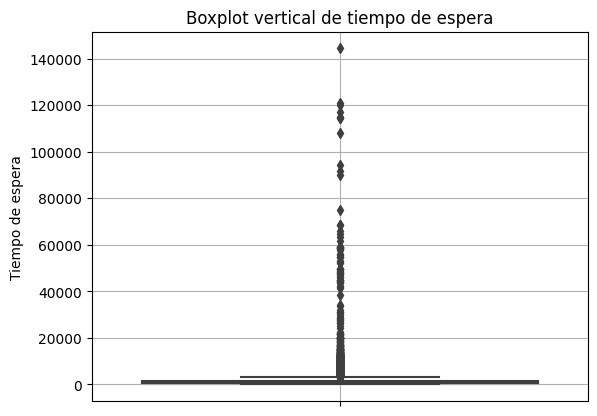

In [216]:
#Primer vistazo a los datos
filtro=telecom_dataset[(telecom_dataset['call_duration'])&(telecom_dataset['call_duration']>0)]
sns.boxplot(y=filtro['call_duration'])  # vertical (parada)
plt.title('Boxplot vertical de tiempo de espera')
plt.ylabel('Tiempo de espera')
plt.grid(True)
plt.show()

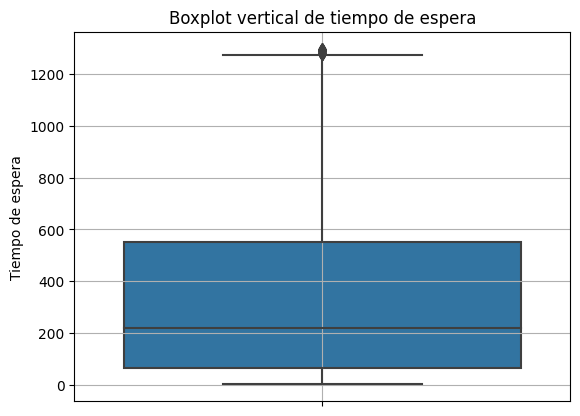

In [217]:
#Se pueden ver varios valores que estan fuera del rango, si ahora paramos los datos en 1300
filtro=telecom_dataset[(telecom_dataset['call_duration']<1300)&(telecom_dataset['call_duration']>0)]
sns.boxplot(y=filtro['call_duration'])  # vertical (parada)
plt.title('Boxplot vertical de tiempo de espera')
plt.ylabel('Tiempo de espera')
plt.grid(True)
plt.show()


vemos que al parar los datos en 1300 los datos se encuentran distribuidos aunque aun se ven valores mas extremos, si paramos los datos en 1200 se vera mas distribuido, se ve que el 75% de los valores esta por debajo de 580 aprox.si paramos los datos en 600

In [218]:
#Quitamos de las dataset el valor de callduration=0 porque puede afectar 
direction_in=telecom_dataset[(telecom_dataset['direction']=='in')&(telecom_dataset['call_duration']>0)&(telecom_dataset['call_duration']<600)]
direction_out=telecom_dataset[(telecom_dataset['direction']=='out')&(telecom_dataset['call_duration']>0)&(telecom_dataset['call_duration']<600)]

In [219]:
#Trabajando con los data sets que tenemos 
#primero realizaremos una prueba levene para determinar si las varianzasa son iguales o no 
#entre los DF de cada grupo y determinar el valor de equal_var= en la prueba ttest_ind()
alpha=0.05
result_variance=st.levene(direction_in['call_duration'],direction_out['call_duration'])
print(result_variance.pvalue)

if (result_variance.pvalue>(alpha)):
    print("No podemos rechazar la hipótesis nula, las varianzas son iguales")
else:
    print("Rechazamos la hipótesis nula, las varianzas no son iguales")


2.0881775167739287e-10
Rechazamos la hipótesis nula, las varianzas no son iguales


In [220]:
#Ahora realizamos la prueba ttest_ind 
results=st.ttest_ind(direction_in['call_duration'],direction_out['call_duration'],equal_var=False)
print(results.pvalue)
if (results.pvalue>(alpha)):
    print("No podemos rechazar la hipótesis nula")
else:
    print("Rechazamos la hipótesis nula")

3.1819738316714614e-15
Rechazamos la hipótesis nula


- Por lo que rechazamos que las llamadas entrantes y salientes tienen la misma duración.

In [221]:
#hipotesis, el tiempo de espera es el mismo para las llamadas entrantes y salientes
#Se determinara los valores que se usaran como limite, ya que tenemos datos que peden alterar
print(np.percentile(telecom_dataset['waiting_time'],[50,60,80]))

[ 60.  99. 299.]


Al probar con esos valores y crear el grafico de caja se ve que como mejor se comporta es con un valor de 99

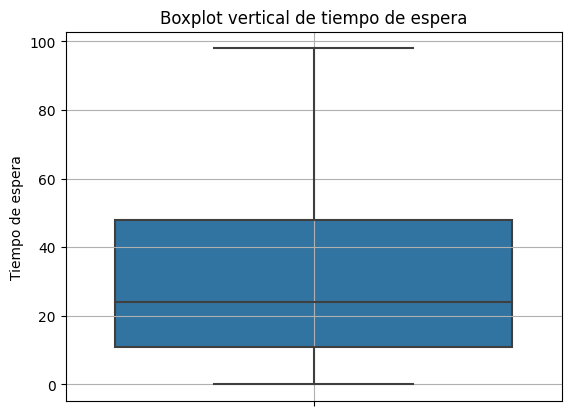

In [222]:

filtro=telecom_dataset[telecom_dataset['waiting_time']<99]
sns.boxplot(y=filtro['waiting_time'])  # vertical (parada)
plt.title('Boxplot vertical de tiempo de espera')
plt.ylabel('Tiempo de espera')
plt.grid(True)
plt.show()

In [223]:
filtro_in=filtro[filtro['direction']=='in']
filtro_out=filtro[filtro['direction']=='out']
print(filtro_in.shape)
print(filtro_out.shape)

(10490, 14)
(16889, 14)


In [224]:
alpha=0.05
result_variance=st.levene(filtro_in['waiting_time'],filtro_out['waiting_time'])
print(result_variance.pvalue)

if (result_variance.pvalue>(alpha)):
    print("No podemos rechazar la hipótesis nula, las varianzas son iguales")
else:
    print("Rechazamos la hipótesis nula, las varianzas no son iguales")


1.3828828982442798e-28
Rechazamos la hipótesis nula, las varianzas no son iguales


In [225]:
#Ahora realizamos la prueba ttest_ind 
results=st.ttest_ind(filtro_in['call_duration'],filtro_out['call_duration'],equal_var=False)
print(results.pvalue)
if (results.pvalue>(alpha)):
    print("No podemos rechazar la hipótesis nula")
else:
    print("Rechazamos la hipótesis nula")

2.0390255200866327e-51
Rechazamos la hipótesis nula


Por lo tanto rechazamos que el tiempo de espera es el mismo para las llamadas entrantes y salientes